In [1]:
! rm -r /content/*
! pip install -q kaggle
! apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


1. Go to your account in kaggle
2. Expire API Token
3. New API Token
4. Upload this file here

### Uploading Kaggle token
or this step can be ignored if data is uploaded locally, in that case, update the `path` variable

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anant31","key":"ea71f82a5751af52e4cdf7e747a3d737"}'}

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d tmdb/tmdb-movie-metadata

  0% 0.00/8.89M [00:00<?, ?B/s]
100% 8.89M/8.89M [00:00<00:00, 78.2MB/s]


In [6]:
! mkdir data

In [7]:
! unzip tmdb-movie-metadata.zip -d data

Archive:  tmdb-movie-metadata.zip
  inflating: data/tmdb_5000_credits.csv  
  inflating: data/tmdb_5000_movies.csv  


**Path to the dataset**

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

In [9]:
! tree /content

/content
├── data
│   ├── tmdb_5000_credits.csv
│   └── tmdb_5000_movies.csv
├── kaggle.json
└── tmdb-movie-metadata.zip

1 directory, 4 files


In [10]:
path = "/content/data/tmdb_5000_movies.csv"

In [11]:
import pandas as pd
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [12]:
import numpy as np

In [13]:
movie_data = pd.read_csv(path)
movie_data.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


### Columns to Drop
Column Name | Reason to Drop | Comments 
---|---|---
homepage | Not of Quantifiable Relevance | Can't justify the impact
original_language | Not used | Languages can be encoded and included for analysis
original_title | Not of Quantifiable relevance | Impact of title can be analysed
overview | Not Quantified for relevance | Can be done for further analyses
production_companies | Not of Quantifiable relevance | Can't justify the impact
production_countries | Not of Quantifiable relevance | Can't justify the impact
spoken_languages | Not of Quantifiable relevance | Languages can be encoded ad included in analysis
tagline | Not of Quantifiable relevance  | Can't justify the impact
title | Not of Quantifiable relevance | Can't justify the impact
id| Not of relevance | Inde is there
<!-- release_date | Not of Quantifiable relevance | Can't justify the impact -->
<!-- status | Not of Quantifiable relevance | Can't justify the impact -->


In [14]:
drop_col = [
    'homepage', 
    'original_language', 
    'original_title', 'overview', 'production_companies', 
    'production_countries', 
#     'release_date',  --- in analysis the month of release is of importance
    'spoken_languages', 
#     'status', 
    'tagline', 'title', 'id'
]

movie_data.drop(drop_col, inplace= True, axis= 1)

In [15]:
movie_data.head()

,budget,genres,keywords,popularity,release_date,revenue,runtime,status,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",150.437577,2009-12-10,2787965087,162.0,Released,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",139.082615,2007-05-19,961000000,169.0,Released,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",107.376788,2015-10-26,880674609,148.0,Released,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",112.312950,2012-07-16,1084939099,165.0,Released,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",43.926995,2012-03-07,284139100,132.0,Released,6.1,2124


In [16]:
movie_data.dtypes

budget            int64
genres           object
keywords         object
popularity      float64
release_date     object
revenue           int64
runtime         float64
status           object
vote_average    float64
vote_count        int64
dtype: object

## Data Cleaning

### Handling Missing Values


In [17]:
# Get the sum and percent of missing values for each attribute
total = movie_data.isnull().sum().sort_values(ascending=False)
percent = (movie_data.isnull().sum()/movie_data.isnull().count() * 100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
runtime,2,0.041641
release_date,1,0.020820
vote_count,0,0.000000
vote_average,0,0.000000
status,0,0.000000
revenue,0,0.000000
popularity,0,0.000000
keywords,0,0.000000
genres,0,0.000000
budget,0,0.000000


### Get columns having `nan`

In [18]:
null_val_col = list(movie_data.columns[[movie_data[col].isnull().values.any() for col in movie_data.columns]])
print("Null Values contained columns:", null_val_col)

Null Values contained columns: ['release_date', 'runtime']


In [19]:
print("Number of nan values in respecctive Columns:\n", {col: movie_data[col].isna().sum() for col in null_val_col})

Number of nan values in respecctive Columns:
 {'release_date': 1, 'runtime': 2}


In [20]:
movie_data.shape

(4803, 10)

- The record with `nan` can be dropped, considering there small quantity.

In [21]:
movie_data.dropna(inplace=True)
movie_data.shape

(4800, 10)

- Remove spaces on the extreme ends if needed.

In [22]:
movie_data[['genres', 'keywords']] = movie_data[['genres', 'keywords']].applymap(str.strip)

### Outlier Analysis

In [23]:
import seaborn as sns
import math

In [24]:
# Define all numerical attributes
numerical_attr = ['vote_count','vote_average','runtime','revenue','popularity','budget']


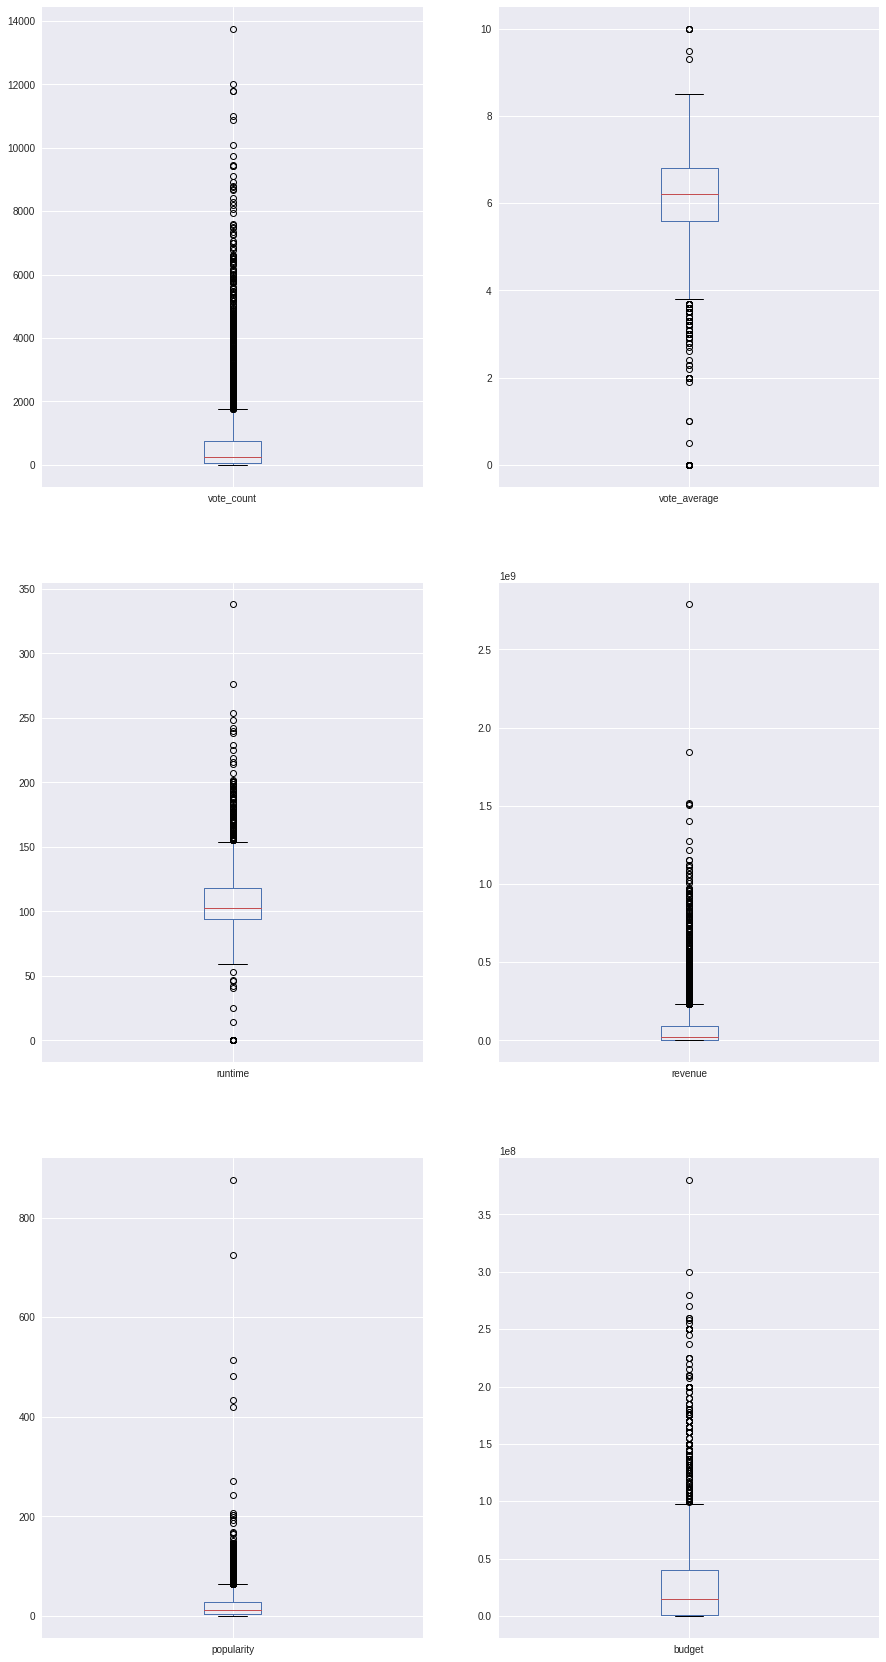

In [25]:
plt.figure(figsize=(15,30))
i = 1
for col in numerical_attr:
    plt.subplot(len(numerical_attr)//2, 2, i)
    i+=1
    fig = movie_data.boxplot(column=col)

In [26]:
# Let us perform binning by median 
def binByMedian(data, bin_size = 2):
    orig_len = len(data)
    num_bins = math.ceil(len(data)/bin_size)
    pad_amt = (num_bins * bin_size) - len(data)
    const_val = data[orig_len - 1]
    
    # pad the data if necessary and reshape to form bins
    init_bin = np.pad(data,(0,pad_amt),'constant',constant_values = (const_val)) 
    init_bin = init_bin.reshape((num_bins,bin_size))
    
    # initiate the median smoothed bins
    median_bins = np.zeros((num_bins,bin_size))
    
    for indx, item in enumerate(init_bin):
        median_bins[indx]  = np.repeat(np.median(item),bin_size)
    
    # flatten the bin and return the smoothened data
    median_bins = median_bins.reshape((median_bins.shape[0] * median_bins.shape[1],))
    return median_bins[:orig_len]

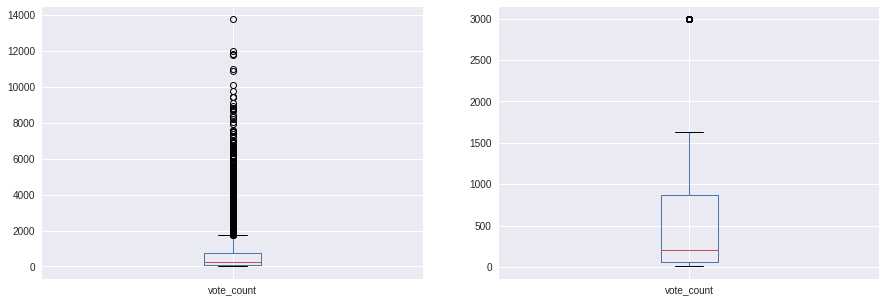

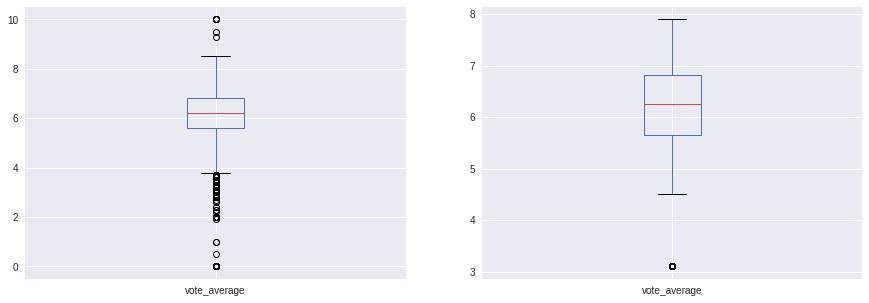

In [27]:
# Create a df copy
df_cp = movie_data.copy()

# Perform binning for 'vote_count'
sel_col = 'vote_count'

# Sort the values by sel_col
df_cp = df_cp.sort_values(by=[sel_col])
df_cp[sel_col] = binByMedian(df_cp[sel_col],bin_size=500)

# plot both the graphs to see the difference
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
movie_data.boxplot(column=sel_col)
plt.subplot(1, 2, 2)
df_cp.boxplot(column=sel_col)
# Perform binning for 'vote_average'
sel_col = 'vote_average'

# Sort the values by sel_col
df_cp = df_cp.sort_values(by=[sel_col])
df_cp[sel_col] = binByMedian(df_cp[sel_col],bin_size=200)

# plot both the graphs to see the difference
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
movie_data.boxplot(column=sel_col)
plt.subplot(1, 2, 2)
df_cp.boxplot(column=sel_col)


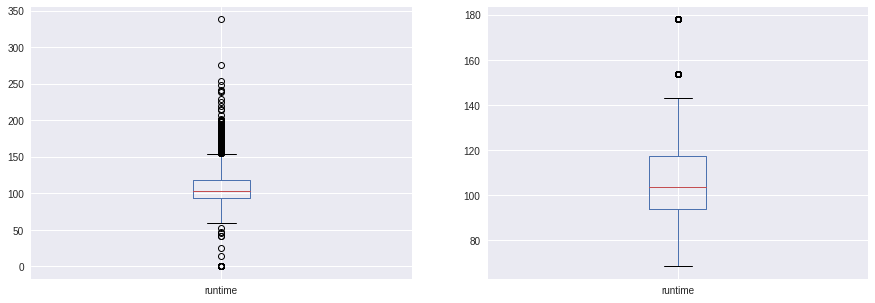

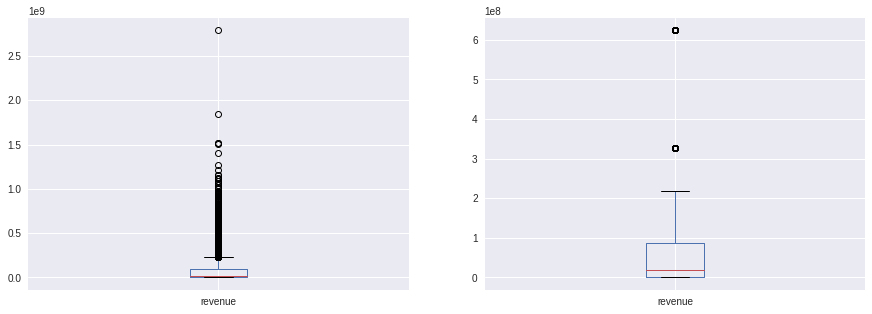

In [28]:
# Perform binning for 'runtime'
sel_col = 'runtime'

# Sort the values by sel_col
df_cp = df_cp.sort_values(by=[sel_col])
df_cp[sel_col] = binByMedian(df_cp[sel_col],bin_size=100)

# plot both the graphs to see the difference
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
movie_data.boxplot(column=sel_col)
plt.subplot(1, 2, 2)
df_cp.boxplot(column=sel_col)

# Perform binning for 'revenue'
sel_col = 'revenue'

# Sort the values by sel_col
df_cp = df_cp.sort_values(by=[sel_col])
df_cp[sel_col] = binByMedian(df_cp[sel_col],bin_size=200)

# plot both the graphs to see the difference
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
movie_data.boxplot(column=sel_col)
plt.subplot(1, 2, 2)
df_cp.boxplot(column=sel_col)


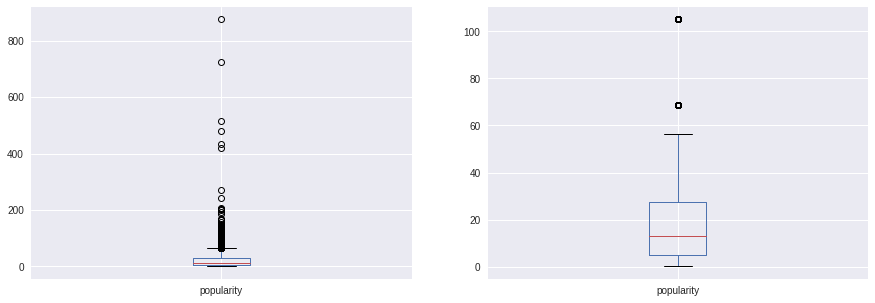

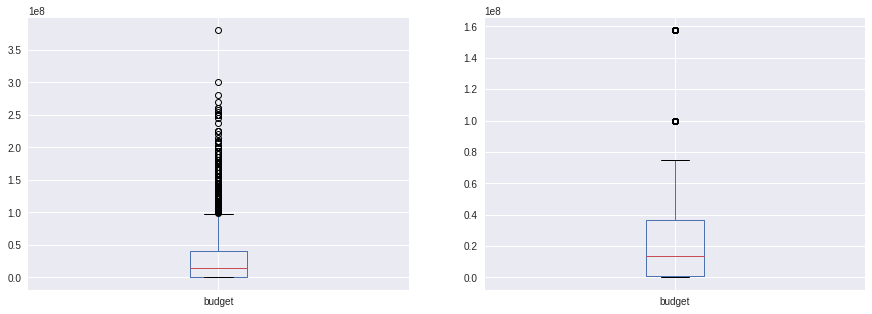

In [29]:
# Perform binning for 'popularity'
sel_col = 'popularity'

# Sort the values by sel_col
df_cp = df_cp.sort_values(by=[sel_col])
df_cp[sel_col] = binByMedian(df_cp[sel_col],bin_size=150)

# plot both the graphs to see the difference
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
movie_data.boxplot(column=sel_col)
plt.subplot(1, 2, 2)
df_cp.boxplot(column=sel_col)

# Perform binning for 'budget'
sel_col = 'budget'

# Sort the values by sel_col
df_cp = df_cp.sort_values(by=[sel_col])
df_cp[sel_col] = binByMedian(df_cp[sel_col],bin_size=200)

# plot both the graphs to see the difference
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
movie_data.boxplot(column=sel_col)
plt.subplot(1, 2, 2)
df_cp.boxplot(column=sel_col)

In [30]:
# Calculate the correlation matrix
correlation = movie_data.corr()

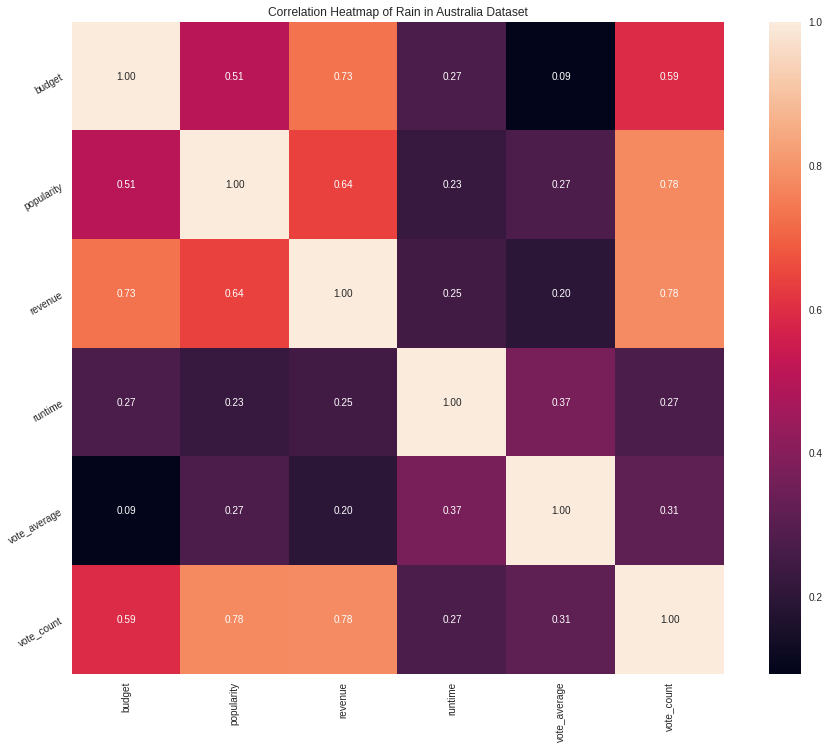

In [31]:
plt.figure(figsize=(16,12))
plt.title('Correlation Heatmap of Rain in Australia Dataset')
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()


We can clearly see that there is a lot of correlation between different attributes. Let's create a pairs plot to see how they match up graphically

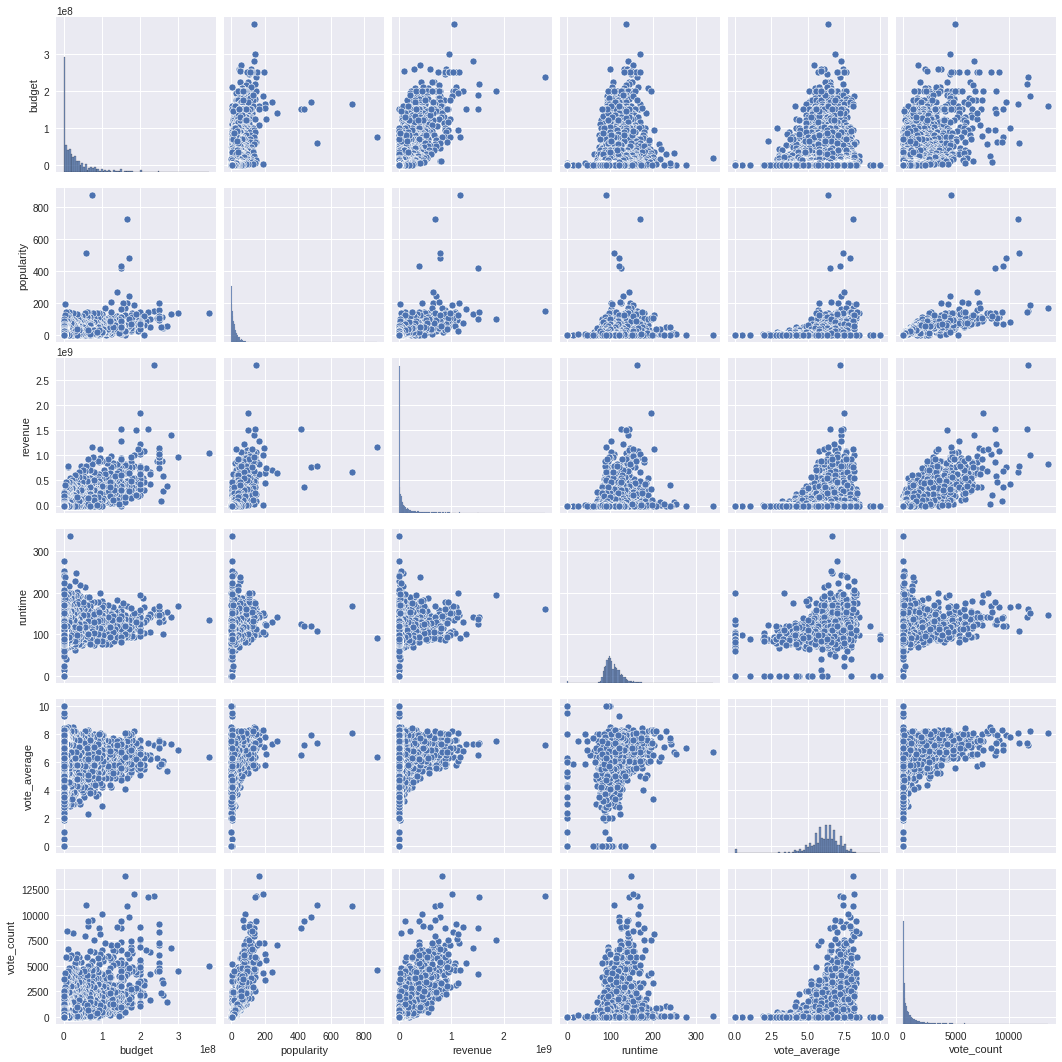

In [32]:
sns.pairplot(movie_data)

The pairsplot seems to visualise the strong correlation (>0.6) that was shown earlier in the heat map between the following attributes:
- *Budget* and *revenue*
- *Popularity* and *revenue*
- *Popularity* and *vote_count*
- *Vote_count* and *revenue*

## Data Extraction

**Information on Month of movie release**
* Get month of release from the release date, conversion to `datetime.datetime` object is not necessary as the string is constant format `%Y-%m-%d` hence the month can directly be extracted.
* The column `release_date` can now be dropped

In [33]:
movie_data.release_date[0], movie_data.release_date[0][5:7]

('2009-12-10', '12')

- Add the `movie_release_month` column to the dataframe and remove the `release_date` column

In [34]:
movie_data['movie_release_month'] = list(map(int, [date[5:7] for date in movie_data.release_date]))
movie_data.drop('release_date', axis= 1, inplace= True)

In [35]:
movie_data.head()

,budget,genres,keywords,popularity,revenue,runtime,status,vote_average,vote_count,movie_release_month
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",150.437577,2787965087,162.0,Released,7.2,11800,12
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",139.082615,961000000,169.0,Released,6.9,4500,5
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",107.376788,880674609,148.0,Released,6.3,4466,10
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",112.312950,1084939099,165.0,Released,7.6,9106,7
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",43.926995,284139100,132.0,Released,6.1,2124,3


In [36]:
"""
a basic string check function, that returns lower case for the string
"""
str_check = lambda in_str: in_str.strip().lower()

In [37]:
movie_data['status'] = list(map(str_check, movie_data['status']))

**Get Genres Information from the Data**
- Get the types of genres names and there resptive codes
- Update the genres extracted to the data `genre_names` column is added
- Delete the `genres` column from the data

In [38]:
import json

In [39]:
uniq_genre = {}
# genre_ids = []
genre_names = []
# movie_data.apply(json.loads) -- doesn't work
for i in movie_data['genres'].index:
    genre_data = movie_data['genres'][i]
    extr_val = json.loads(genre_data)
#     genre_id = []
    genre_name = []
    for k in extr_val:
        genre_name_str = str_check(k['name'])
#         genre_id.append(int(k['id']))
        genre_name.append(genre_name_str)
        if k['id'] not in uniq_genre:
            uniq_genre[k['id']] = genre_name_str
#     genre_ids.append(genre_id)
    genre_names.append(genre_name)

movie_data.drop('genres', axis= 1, inplace= True)
# movie_data['genre_ids'] = genre_ids
movie_data['genre_names'] = genre_names

In [40]:
pd.DataFrame(uniq_genre.items(), columns= ['id', 'name'])

,id,name
0,28,action
1,12,adventure
2,14,fantasy
3,878,science fiction
4,80,crime
5,18,drama
6,53,thriller
7,16,animation
8,10751,family
9,37,western


In [41]:
movie_data.columns

Index(['budget', 'keywords', 'popularity', 'revenue', 'runtime', 'status',
       'vote_average', 'vote_count', 'movie_release_month', 'genre_names'],
      dtype='object')

**Get Keywords Information from the Data**
- Get the types of genres names and there resptive codes
- Update the keywords extracted to the data `keyword_names` column is added
- Delete the `keywords` column from the data

In [42]:
uniq_keyword = {}
# keyword_ids = []
keyword_names = []
# movie_data.apply(json.loads) -- doesn't work
for i in movie_data['keywords'].index:
    keyword_data = movie_data['keywords'][i]
    extr_val = json.loads(keyword_data)
#     keyword_id = []
    keyword_name = []
    for k in extr_val:
        keyword_name_str = str_check(k['name'])
#         keyword_id.append(int(k['id']))
        keyword_name.append(keyword_name_str)
        if k['id'] not in uniq_keyword:
            uniq_keyword[k['id']] = keyword_name_str
#     keyword_ids.append(keyword_id)
    keyword_names.append(keyword_name)

movie_data.drop('keywords', axis= 1, inplace= True)
# movie_data['keyword_ids'] = keyword_ids
movie_data['keyword_names'] = keyword_names

In [43]:
pd.DataFrame(uniq_keyword.items(), columns=['id', 'name'])

,id,name
0,1463,culture clash
1,2964,future
2,3386,space war
3,3388,space colony
4,3679,society
...,...,...
9803,177927,homeless
9804,162740,arms
9805,187891,paper knife
9806,206558,guitar case


* Between `genres` and `keywords`, it would be better to include `genres` in the furhter analyis as the number of keywords is too much to be considered in the analysis, the `genres` on the other hand, are only 20.

In [44]:
movie_data.drop('keyword_names', axis= 1, inplace= True)

## Data Transformation
Binarize Genre categorical data

In [45]:
movie_data.head()

,budget,popularity,revenue,runtime,status,vote_average,vote_count,movie_release_month,genre_names
0,237000000,150.437577,2787965087,162.0,released,7.2,11800,12,"[action, adventure, fantasy, science fiction]"
1,300000000,139.082615,961000000,169.0,released,6.9,4500,5,"[adventure, fantasy, action]"
2,245000000,107.376788,880674609,148.0,released,6.3,4466,10,"[action, adventure, crime]"
3,250000000,112.312950,1084939099,165.0,released,7.6,9106,7,"[action, crime, drama, thriller]"
4,260000000,43.926995,284139100,132.0,released,6.1,2124,3,"[action, adventure, science fiction]"


In [46]:
genre_data = pd.DataFrame(np.zeros((movie_data.shape[0], len(uniq_genre))), \
                          columns= uniq_genre.values(), dtype= np.int)

The `reset_index()` is vital as comparisions, assignments etc. with other dataframes are done by comparing indexes.

In [47]:
movie_data.reset_index(inplace= True)
movie_data.drop('index', inplace= True, axis= 1)

In [48]:
for i in range(movie_data['genre_names'].shape[0]):
    genre_name_list = movie_data['genre_names'].iloc[i]
    for x in genre_name_list:
        genre_data[x].iloc[i] = 1

In [49]:
for col in genre_data.columns:
    movie_data['genre_' + col] = genre_data[col]
movie_data.drop('genre_names', axis= 1, inplace= True)

In [50]:
movie_data.head()

,budget,popularity,revenue,runtime,status,vote_average,vote_count,movie_release_month,genre_action,genre_adventure,genre_fantasy,genre_science fiction,genre_crime,genre_drama,genre_thriller,genre_animation,genre_family,genre_western,genre_comedy,genre_romance,genre_horror,genre_mystery,genre_history,genre_war,genre_music,genre_documentary,genre_foreign,genre_tv movie
0,237000000,150.437577,2787965087,162.0,released,7.2,11800,12,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,300000000,139.082615,961000000,169.0,released,6.9,4500,5,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,245000000,107.376788,880674609,148.0,released,6.3,4466,10,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,250000000,112.312950,1084939099,165.0,released,7.6,9106,7,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,260000000,43.926995,284139100,132.0,released,6.1,2124,3,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [51]:
from sklearn.preprocessing import LabelBinarizer

In [52]:
encoder_status = LabelBinarizer()
movie_data['status'] = encoder_status.fit_transform(movie_data['status'])

In [53]:
movie_data.head()

,budget,popularity,revenue,runtime,status,vote_average,vote_count,movie_release_month,genre_action,genre_adventure,genre_fantasy,genre_science fiction,genre_crime,genre_drama,genre_thriller,genre_animation,genre_family,genre_western,genre_comedy,genre_romance,genre_horror,genre_mystery,genre_history,genre_war,genre_music,genre_documentary,genre_foreign,genre_tv movie
0,237000000,150.437577,2787965087,162.0,0,7.2,11800,12,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,300000000,139.082615,961000000,169.0,0,6.9,4500,5,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,245000000,107.376788,880674609,148.0,0,6.3,4466,10,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,250000000,112.312950,1084939099,165.0,0,7.6,9106,7,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,260000000,43.926995,284139100,132.0,0,6.1,2124,3,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Visualization

In [54]:
# Helper Function
def plotHistogram(df,col,tit='',xlabel='',ylabel='',log=False):
    bins = np.linspace(df[col].min(),df[col].max(),25)
    plt.xlim([df[col].min(),df[col].max()])
    plt.hist(df[col], bins=bins, alpha=0.5,log=log)
    plt.title(tit)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

**Let us take a look at the revenue histogram**

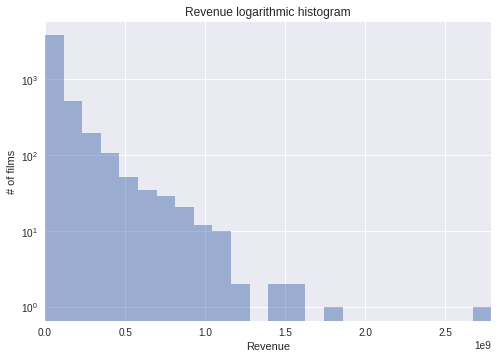

In [55]:
plotHistogram(movie_data,'revenue',ylabel='# of films',xlabel='Revenue',tit='Revenue logarithmic histogram',log=True)

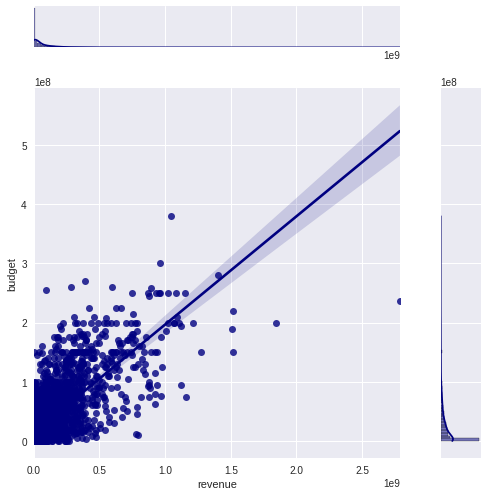

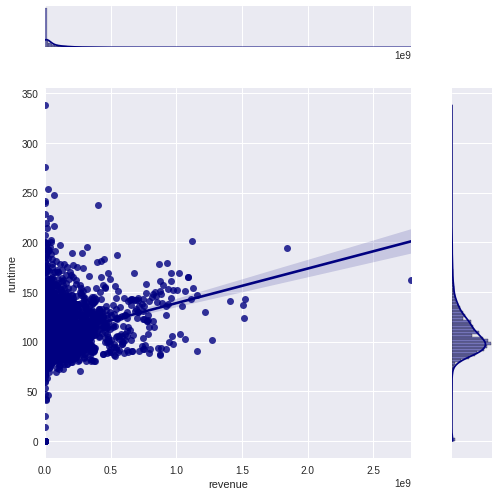

In [56]:
# Compare with budget
sns.jointplot(x='revenue', y='budget', data=movie_data, color='navy', height=7, space=1, kind='reg')
# Compare with runtime
sns.jointplot(x='revenue', y='runtime', data=movie_data, color='navy', height=7, space=1, kind='reg')


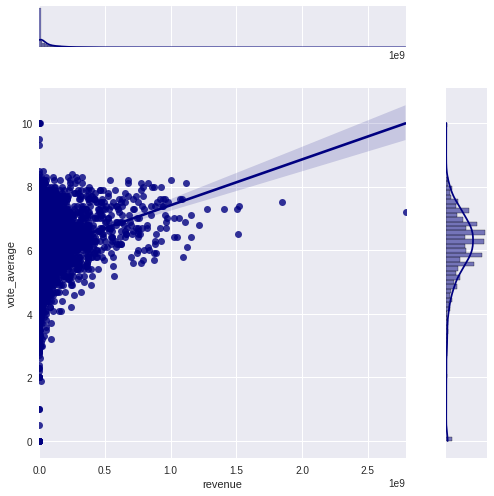

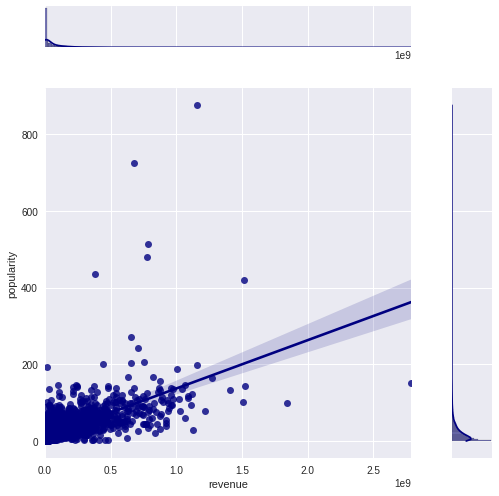

In [57]:
# Compare with vote_average
sns.jointplot(x='revenue', y='vote_average', data=movie_data, color='navy', height=7, space=1, kind='reg')

# Compare with popularity
sns.jointplot(x='revenue', y='popularity', data=movie_data, color='navy', height=7, space=1, kind='reg')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


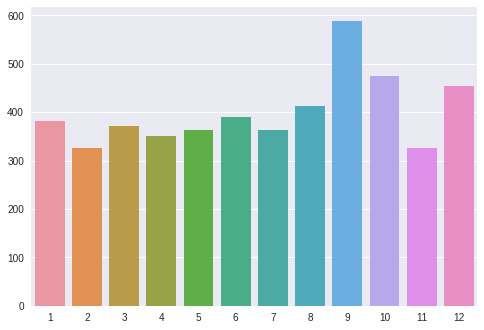

In [58]:
cnt = movie_data.sort_values(by=['movie_release_month'])['movie_release_month'].value_counts()
cnt = cnt.sort_index()
x = np.array(cnt.index)
y = np.array(cnt.values)

sns.barplot(x,y)
plt.show()


**Does High Budget Mean High Popularity ?**

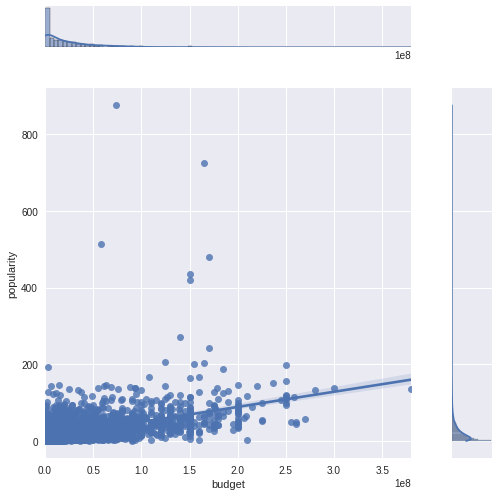

In [59]:
sns.jointplot(x='budget', y='popularity', data=movie_data, height=7, space=1, kind='reg')
plt.show()

## Predictive Analytics

In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [61]:
cols = list(set(movie_data.columns) - set(['revenue']))
cols

['genre_comedy',
 'genre_crime',
 'status',
 'genre_action',
 'genre_romance',
 'genre_tv movie',
 'vote_count',
 'genre_thriller',
 'genre_documentary',
 'genre_mystery',
 'vote_average',
 'genre_animation',
 'genre_science fiction',
 'genre_music',
 'genre_history',
 'genre_horror',
 'movie_release_month',
 'genre_western',
 'genre_foreign',
 'popularity',
 'genre_adventure',
 'budget',
 'runtime',
 'genre_war',
 'genre_fantasy',
 'genre_family',
 'genre_drama']

In [62]:
# Get the X and y from the df
X_orig = movie_data[cols][movie_data['revenue'] != 0].values
y_orig = movie_data['revenue'][movie_data['revenue'] != 0].values
print(X_orig)
print(y_orig)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]]
[2787965087  961000000  880674609 ...      99000     424760    2040920]


In [63]:
# Let us now split into to train and test: 80-20 approx
X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=0.2, random_state=42)
print(X_train,y_train)

[[0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]] [ 20374201 214015089   3200000 ...  77477008 273552592    150277]


In [64]:
print('Shape of X-train is {}'.format(X_train.shape))
print('Shape of y-train is {}'.format(y_train.shape))
print('Shape of X-test is {}'.format(X_test.shape))
print('Shape of y-test is {}'.format(y_test.shape))

Shape of X-train is (2700, 27)
Shape of y-train is (2700,)
Shape of X-test is (676, 27)
Shape of y-test is (676,)


The attributes involved here are continuous and hence we're using the standard scaler which will reduce the mean to 0 and variance to 1 of each attribute to make them more comparable with each other and not affect the learning model due to their magnitudes

In [65]:
# Normalize the train input
scaler_train = StandardScaler()
X_train = scaler_train.fit_transform(X_train)
print(X_train)

[[-0.7218911  -0.42738086  0.         ... -0.34487546 -0.36014874
   1.09566829]
 [-0.7218911   2.33983336  0.         ... -0.34487546 -0.36014874
   1.09566829]
 [-0.7218911   2.33983336  0.         ... -0.34487546 -0.36014874
   1.09566829]
 ...
 [ 1.38525049 -0.42738086  0.         ... -0.34487546 -0.36014874
  -0.91268499]
 [ 1.38525049 -0.42738086  0.         ... -0.34487546 -0.36014874
   1.09566829]
 [-0.7218911  -0.42738086  0.         ... -0.34487546 -0.36014874
   1.09566829]]


In [66]:
# Normalize the test input
X_test = scaler_train.transform(X_test)

### Linear Regression
The frequentist approach towards the continuous value prediction, here we the value predicted is taken as a linear combination of the input parameters and a bias factor.

Advantages | Disadvantages
---|---
Linear regression performs exceptionally well for linearly separable data |	The assumption of linearity between dependent and independent variables
Easier to implement, interpret and efficient to train |	It is often quite prone to noise and overfitting|
It handles overfitting pretty well using dimensionally reduction techniques, regularization, and cross-validation	| Linear regression is quite sensitive to outliers
One more advantage is the extrapolation beyond a specific data set | It is prone to multicollinearity

In [67]:
import scipy.stats as stats
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [68]:
def linear_regression(X, y, df):
    mod = sm.OLS(endog= y, exog=X).fit()
    influence = mod.get_influence()

    res = df.copy()
    res['resid'] = mod.resid
    res['fittedvalues'] = mod.fittedvalues
    res['resid_std'] = mod.resid_pearson
    res['leverage'] = influence.hat_matrix_diag
    res['norm_residuals_sqrt'] = np.abs(np.sqrt(influence.resid_studentized_internal))
    res.drop(list(df.columns), inplace= True, axis= 1)
    return mod, res

In [69]:
def plot_diagnosis(df, model):
    fig, axes = plt.subplots(nrows=2, ncols=2)
    plt.style.use('seaborn')

    # Residual against fitted values.
    sns.residplot(
        x='fittedvalues', y='resid', data= df,  ax=axes[0, 0], 
        lowess=True,
        scatter_kws={'alpha': 0.5},
        line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}
    )
    axes[0, 0].axhline(y=0, color='grey', linestyle='dashed')
    axes[0, 0].set_xlabel('Fitted Values')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title('Residuals vs Fitted')

    # qqplot
    sm.qqplot(
        df['resid'], dist=stats.t, fit=True, line='45',
        ax=axes[0, 1], c='#4C72B0'
    )
    axes[0, 1].set_title('Normal Q-Q')

    # The scale-location plot.
    sns.regplot(
        x='fittedvalues', y='norm_residuals_sqrt', ax=axes[1, 0], data= df,
        lowess=True,
        scatter_kws={'alpha': 0.5},
        line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}
    )
    axes[1, 0].axhline(y=0, color='grey', linestyle='dashed')
    axes[1, 0].set_xlabel('Fitted values')
    axes[1, 0].set_ylabel('Sqrt(|standardized residuals|)')
    axes[1, 0].set_title('Scale-Location')

    # Standardized residuals vs. leverage
    sns.scatterplot(
        x='leverage', y='resid_std', ax=axes[1, 1], data= df
    )

    axes[1, 1].axhline(y=0, color='grey', linestyle='dashed')
    axes[1, 1].set_xlabel('Leverage')
    axes[1, 1].set_ylabel('Sqrt(|standardized residuals|)')
    axes[1, 1].set_title('Residuals vs Leverage')

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:695: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


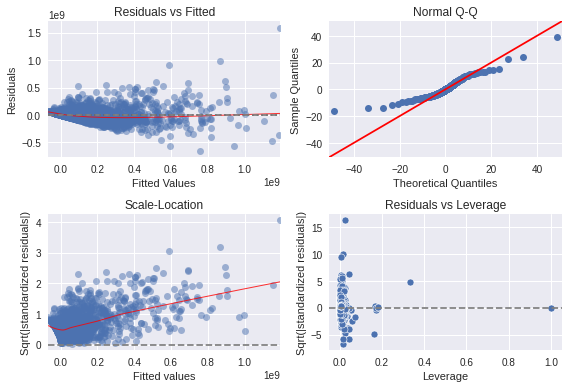

In [70]:
model, model_data = linear_regression(X_orig, y_orig, movie_data[movie_data['revenue'] != 0])
plot_diagnosis(model_data, model)

#### Diagnostics####
1. **Residual Fitted Plot**

    This plot shows a slight bend towards the beginning, hence we can say that there is some non-linear behaviour in the relation between output and features.

2. **Normal Q-Q**

    The curve in the normal qq shows that the data is a heavy tailed distribution, that is there is a larger probability of getting very large values.

3. **Scale Location Plot**

    Scale-Location plot shows whether residuals are spread equally along the ranges of input variables (predictor).
    The curve in the beginning can be a result of the skewness in the data and not because of not capturing non-linearity in the relation.

4. **Residual-Leverage Plot**

    Leverage have unusually high `X` values, the deviations from the line show the values, the more deviation from the horizontal line the higher the deviation. Here the deviation data points are very high and can be considered as influencing the model very much due to there quantity.

#### Conclusion####
  Perhaps the linear regression model may not have been the best fit model for this dataset, with one of the reasons being that few of the attributes are strongly correlated with each other.


### Decision Tree Regressor

In [71]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
regressor = DecisionTreeRegressor(random_state=0).fit(X_train,y_train)
regressor.score(X_train, y_train)

1.0

In [72]:
cross_val_score(regressor, X_test, y_test, cv=10)

array([ 0.45255533,  0.09977063,  0.58851623, -0.78682361,  0.34654802,
        0.46138129,  0.30227544,  0.57888375,  0.37632349, -0.55113295])

In [73]:
regressor.score(X_test, y_test)

0.6293203998674344

In [74]:
y_pred = regressor.predict(X_test)

In [75]:
metrics.mean_squared_error(y_pred,y_test)

1.9133135073747096e+16

The decision tree performs decently. Perhaps it's performance can be improved using ensemble learning - the random forest, which we shall try next.

### Random Forest Regressor

In [76]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=0).fit(X_train, y_train)
model.score(X_train, y_train)

0.9665960879221963

Here, we attempt an ensemble learning method to better our previous results. Random forests basically merge different decision trees trained differently on different data to avoid overfitting and put together a final predictor value based on all of the trees involved. 

In [77]:
model.score(X_test, y_test)

0.7291499351759507

The training set performs significantly better than the test set. One might think this is due to overfitting, but it is unlikely in a random forest model. And this was verified by changing the parameters like number of trees from 100 to something lower and the score was not affected much. However, one reason could be due to the test set having values outside that of the training, and unlike in linear regression, random forest regression cannot discover trends that would help it extrapolate in the cases where the test set values fall outside the training zone.

### Decision Tree Classifier

In [78]:
X = movie_data[movie_data['revenue'] != 0][cols].values
y = movie_data[movie_data['revenue'] != 0]['revenue']

In [79]:
y = pd.cut(y, bins= 4, duplicates= 'drop')
from sklearn.preprocessing import LabelEncoder
y = LabelEncoder().fit(y).transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
from sklearn.tree import DecisionTreeClassifier
dec_tree_model = DecisionTreeClassifier(max_depth= 5).fit(X_train, y_train)
dec_tree_model.score(X_train, y_train)

0.9911111111111112

In [81]:
dec_tree_model.score(X_test, y_test)

0.9615384615384616

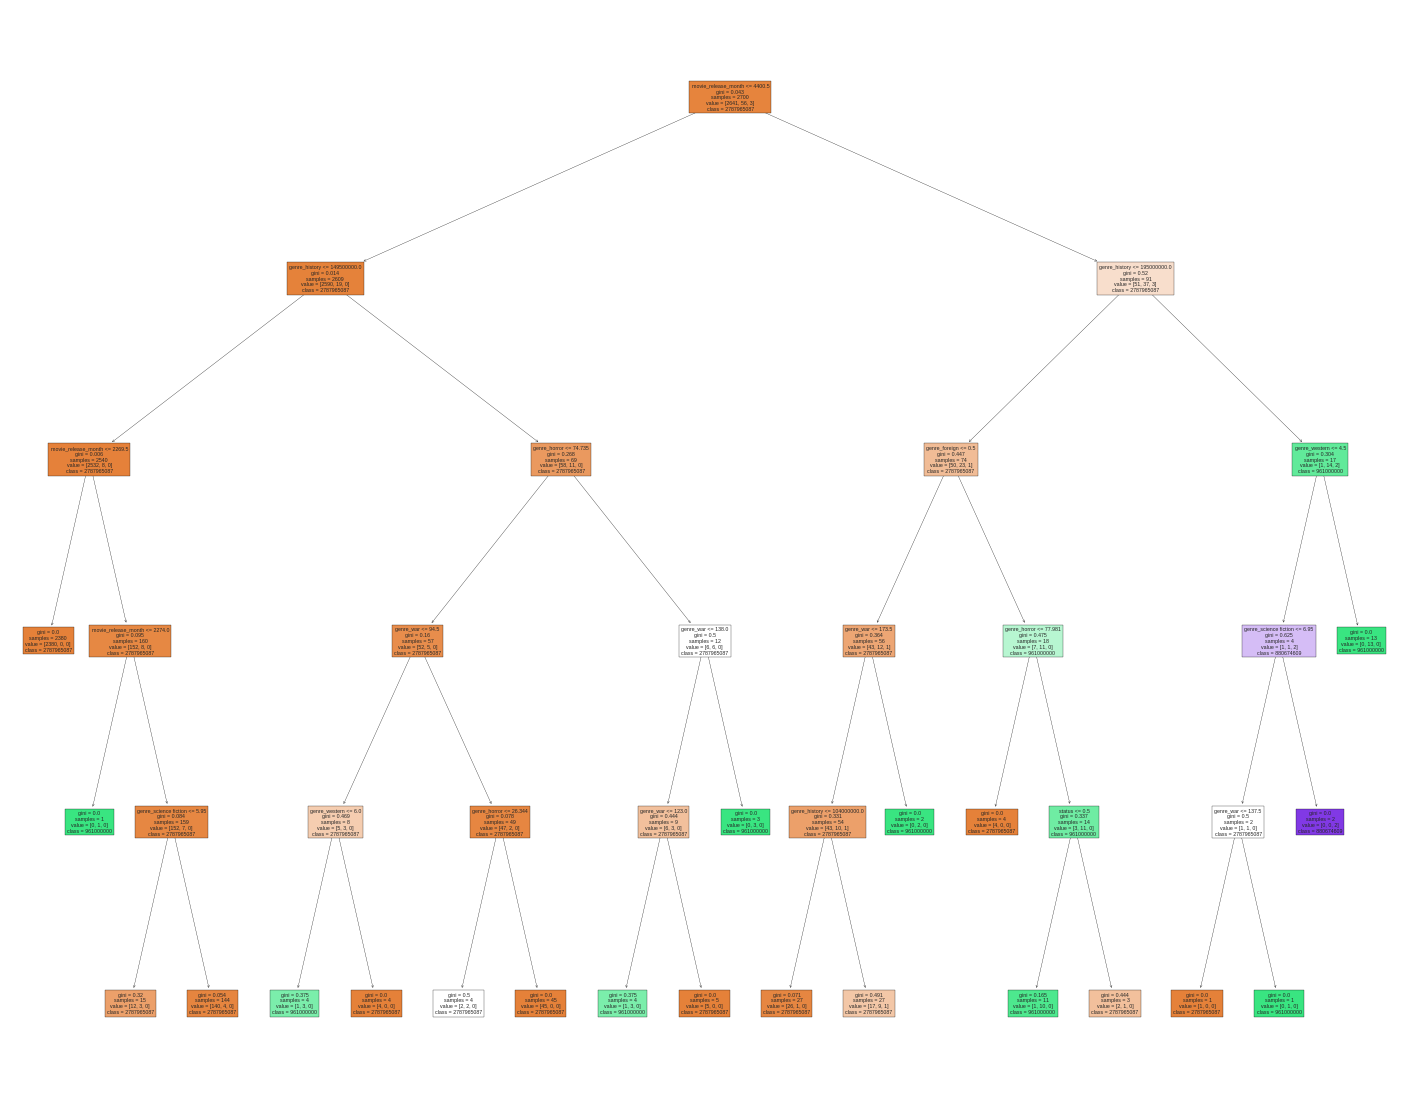

In [82]:
from sklearn import tree
featureNames = movie_data.drop('revenue', axis=1).columns

targetNames = movie_data["revenue"].astype(str).unique().tolist()
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dec_tree_model,
                   feature_names=featureNames,  
                   class_names=targetNames, filled = True)

Here, we've binned the revenue column into 4 discrete values so that we can run a decision tree classifier. The model has been visualised above for a depth of 5. The reason for doing this is to leverage the interpretability of a decision tree and to see how it's working which can be seen once you zoom in. Binning it also gets us the best accuracy possible of 96% with the test set.

### Random Forest Classifier

In [83]:
from sklearn.ensemble import RandomForestClassifier
rand_clf = RandomForestClassifier(max_depth = 20).fit(X_train, y_train)
rand_clf.score(X_train, y_train)

1.0

In [84]:
rand_clf.score(X_test, y_test)

0.9733727810650887

The random forest is an ensemble learning method using a decision tree. Like we tried with the regression tree -> random forest regression, we now try the same. However, here there's not much of an improvement as 96% becomes 97%. For the sake of interpretability, a decision tree model that is 96% accurate should be preferred.

---

## Inference 


We've tried a few models here, and the random forest regression and decision tree classifier once binned seem to work the best. Of course, there is always room for improvement. Thank you for reading this!